In [1]:
import time
import requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import confluent_kafka
from bs4 import BeautifulSoup
import uuid
from pykafka import KafkaClient
from kafka import KafkaProducer
from kafka import KafkaConsumer


# Communities comparison

## Scraping Github figure

Pykafka : https://github.com/Parsely/pykafka  
Kafka Python : https://github.com/dpkp/kafka-python/  
Confluent Kafka : https://github.com/confluentinc/confluent-kafka-python


In [2]:
def scrap(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    info =[]
    for i in range(0,len(soup.find_all('div', class_='Layout-sidebar')[0].find_all('div', class_='mt-2'))):
        info.append(\
        soup.find_all('div', class_='Layout-sidebar')[0].\
        find_all('div', class_='mt-2')[i].\
        text.replace('\n', '').\
        replace('    ', ' ')\
        )
    
    if soup.find_all('div', class_='Layout-sidebar')[0].find_all('relative-time'):
        date = soup.find_all('div', class_='Layout-sidebar')[0].find_all('relative-time')[0].text
    else :
        date = 'No offcial release'
    
    return [[x for x in info if 'stars' in x][0].replace('stars',""),\
            [x for x in info if 'watching' in x][0].replace('watching',""),\
            [x for x in info if 'forks' in x][0].replace('forks',""),\
            date
           ]

def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'k' in x:
        if len(x) > 1:
            return float(x.replace('k', '')) * 1000
        return 1000.0
    if 'm' in x:
        if len(x) > 1:
            return float(x.replace('m', '')) * 1000000
        return 1000000.0
    if 'b' in x:
        return float(x.replace('b', '')) * 1000000000
    return float(x)

In [3]:
listeframework = ['Pykafka','Kafka Python','Confluent Python']


listeurl = ['https://github.com/Parsely/pykafka',
            'https://github.com/dpkp/kafka-python/',
            'https://github.com/confluentinc/confluent-kafka-python']

In [4]:
dico = {listeframework[i]: scrap(listeurl[i]) for i in range(0, len(listeframework))}

df = pd.DataFrame.from_dict(dico,orient='index',columns=['Stars','Watching','Forks','Laste release date'])



In [5]:
df['Stars'] = df['Stars'].apply(value_to_float)
df['Watching'] = df['Watching'].apply(value_to_float)
df['Forks'] = df['Forks'].apply(value_to_float)



## Table

In [6]:
df

,Stars,Watching,Forks,Laste release date
Pykafka,1100.0,75.0,230.0,"Sep 24, 2018"
Kafka Python,5100.0,154.0,1300.0,"Sep 30, 2020"
Confluent Python,3100.0,276.0,811.0,"Jan 24, 2023"


#  Performance comparison 

In [7]:
bootstrap_servers = 'localhost:9092'
producer_timings = {}
consumer_timings = {}

In [8]:
msg_count = 1_000_000
msg_size = 200
msg_payload = ('benchkafka' * 2000).encode()[:msg_size]
print(msg_payload)
print(len(msg_payload))

b'benchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafkabenchkafka'
200


In [9]:
def calculate_thoughput(timing, n_messages=1000000, msg_size=100):
    print("Processed {0} messsages in {1:.2f} seconds".format(n_messages, timing))
    print("{0:.2f} MB/s".format((msg_size * n_messages) / timing / (1024*1024)))
    print("{0:.2f} Msgs/s".format(n_messages / timing))

## Pykafka

In [10]:

def pykafka_producer_performance(use_rdkafka=False):
    
    # Setup client
    client = KafkaClient(hosts=bootstrap_servers)
    topic = client.topics[b'pykafka-test-topic']
    producer = topic.get_producer(use_rdkafka=use_rdkafka)

    msgs_produced = 0
    produce_start = time.time()
    for i in range(msg_count):
        # Start producing
        producer.produce(msg_payload) 
                     
    producer.stop() # Will flush background queue
 
    return time.time() - produce_start


In [11]:
client = KafkaClient(hosts=bootstrap_servers)
producer_timings['pykafka'] = pykafka_producer_performance()
calculate_thoughput(producer_timings['pykafka'])

Processed 1000000 messsages in 17.06 seconds
5.59 MB/s
58602.03 Msgs/s


In [12]:
def pykafka_consumer_performance(use_rdkafka=False):
    # Setup client
    client = KafkaClient(hosts=bootstrap_servers)
    topic = client.topics[b'pykafka-test-topic']

    msg_consumed_count = 0
    
    consumer_start = time.time()
    # Consumer starts polling messages in background thread, need to start timer here
    consumer = topic.get_simple_consumer(use_rdkafka=use_rdkafka)

    while True:
        msg = consumer.consume()
        if msg:
            msg_consumed_count += 1

        if msg_consumed_count >= msg_count:
            break
                        
    consumer_timing = time.time() - consumer_start
    consumer.stop()    
    return consumer_timing

In [13]:
consumer_timings['pykafka'] = pykafka_consumer_performance(use_rdkafka=False)
calculate_thoughput(consumer_timings['pykafka'])

Processed 1000000 messsages in 11.87 seconds
8.04 MB/s
84275.13 Msgs/s


## Kafka Python

In [14]:
def python_kafka_producer_performance():
    producer = KafkaProducer(bootstrap_servers=bootstrap_servers)

    producer_start = time.time()
    topic = 'python-kafka-topic'
    for i in range(msg_count):
        producer.send(topic, msg_payload)
        
    producer.flush() # clear all local buffers and produce pending messages
        
    return time.time() - producer_start

In [15]:
producer_timings['python_kafka'] = python_kafka_producer_performance()
calculate_thoughput(producer_timings['python_kafka'])

Processed 1000000 messsages in 46.70 seconds
2.04 MB/s
21411.97 Msgs/s


In [16]:

def python_kafka_consumer_performance():
    topic = 'python-kafka-topic'

    consumer = KafkaConsumer(
        bootstrap_servers=bootstrap_servers,
        auto_offset_reset = 'earliest', # start at earliest topic
        group_id = None # do no offest commit
    )
    msg_consumed_count = 0
            
    consumer_start = time.time()
    consumer.subscribe([topic])
    for msg in consumer:
        msg_consumed_count += 1
        
        if msg_consumed_count >= msg_count:
            break
                    
    consumer_timing = time.time() - consumer_start
    consumer.close()    
    return consumer_timing

In [17]:
consumer_timings['python_kafka'] = python_kafka_consumer_performance()
calculate_thoughput(consumer_timings['python_kafka'])

Processed 1000000 messsages in 8.35 seconds
11.42 MB/s
119762.45 Msgs/s


## Confluent Kafka

In [45]:
topic = 'confluent-kafka-topic'

def confluent_kafka_producer_performance():
    
    topic = 'confluent-kafka-topic'
    conf = {'bootstrap.servers': bootstrap_servers}
    producer = confluent_kafka.Producer(**conf)
    messages_to_retry = 0

    producer_start = time.time()
    for i in range(msg_count):
        try:
            producer.produce(topic, value=msg_payload)      
        except BufferError as e:
            messages_to_retry += 1

    # hacky retry messages that over filled the local buffer
    for i in range(messages_to_retry):
        producer.poll(0)
        try:
            producer.produce(topic, value=msg_payload)
        except BufferError as e:
            producer.poll(0)
        #    producer.produce(topic, value=msg_payload)

    producer.flush()
            
    return time.time() - producer_start

In [46]:
producer = confluent_kafka.Producer({'bootstrap.servers': bootstrap_servers})


In [47]:
for i in (0,20):
    producer.poll(i)

In [48]:
producer_timings['confluent_kafka'] = confluent_kafka_producer_performance()
calculate_thoughput(producer_timings['confluent_kafka'])

Processed 1000000 messsages in 1.26 seconds
75.50 MB/s
791695.54 Msgs/s


In [49]:
client = KafkaClient(hosts=bootstrap_servers)
topic = client.topics[b'confluent-kafka-topic']
print(topic.earliest_available_offsets())
print(topic.latest_available_offsets())

{0: OffsetPartitionResponse(offset=[0], err=0)}
{0: OffsetPartitionResponse(offset=[3699755], err=0)}


In [50]:
def confluent_kafka_consumer_performance():
    
    topic = 'confluent-kafka-topic'
    msg_consumed_count = 0
    conf = {'bootstrap.servers': bootstrap_servers,
            'group.id': uuid.uuid1(),
            'session.timeout.ms': 6000,
            'default.topic.config': {
                'auto.offset.reset': 'earliest'
            }
    }

    consumer = confluent_kafka.Consumer(**conf)

    consumer_start = time.time()
    # This is the same as pykafka, subscribing to a topic will start a background thread
    consumer.subscribe([topic])

    while True:
        msg = consumer.poll(1)
        if msg:
            msg_consumed_count += 1
                         
        if msg_consumed_count >= msg_count:
            break
                    
    consumer_timing = time.time() - consumer_start
    consumer.close()    
    return consumer_timing

In [51]:
#_ = confluent_kafka_consumer_performance() # Warm cache
consumer_timings['confluent_kafka'] = confluent_kafka_consumer_performance()
calculate_thoughput(consumer_timings['confluent_kafka'])

Processed 1000000 messsages in 2.04 seconds
46.66 MB/s
489291.89 Msgs/s


## Dataframes

In [52]:
consumer_df = pd.DataFrame.from_dict(consumer_timings, orient='index').rename(columns={0: 'time_in_seconds'})
producer_df = pd.DataFrame.from_dict(producer_timings, orient='index').rename(columns={0: 'time_in_seconds'})
consumer_df['MBs/s'] = (len(msg_payload) * msg_count) / consumer_df.time_in_seconds / (1024*1024)
producer_df['MBs/s'] = (len(msg_payload) * msg_count) / producer_df.time_in_seconds / (1024*1024)
consumer_df['Msgs/s'] = msg_count / consumer_df.time_in_seconds
producer_df['Msgs/s'] = msg_count / producer_df.time_in_seconds

In [53]:
#producer_df.sort_index(inplace=True)
producer_df

,time_in_seconds,MBs/s,Msgs/s
pykafka,17.064255,11.177450,58602.030973
python_kafka,46.702852,4.084009,21411.968693
confluent_kafka,1.263112,151.003940,791695.538305


## Graphic comparison (plots)

### Megabyte and messages number per second

In [54]:
producer_df['k Msgs/s'] = producer_df['Msgs/s']/1000
consumer_df['k Msgs/s'] = consumer_df['Msgs/s']/1000

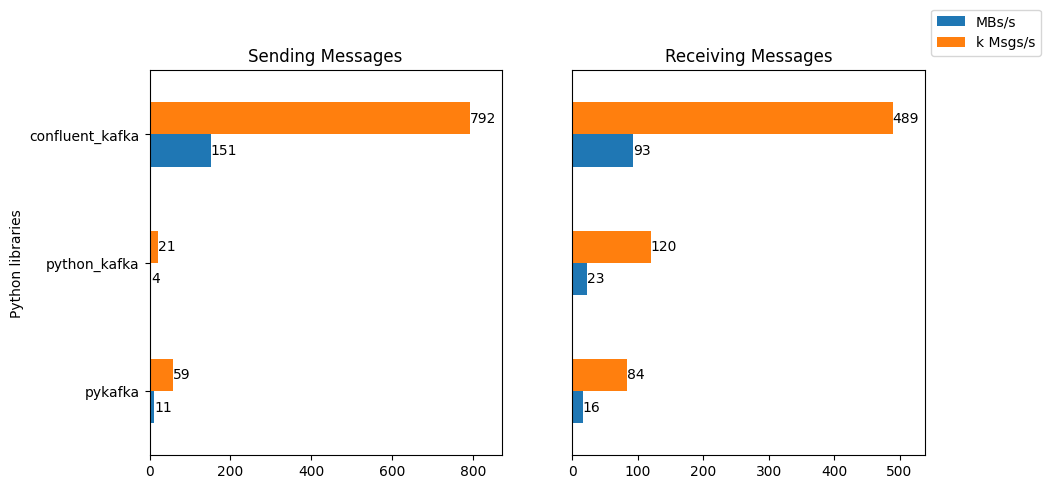

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = producer_df[['MBs/s','k Msgs/s']].plot(kind='barh',\
                                             ylabel='Python libraries',\
                                            title='Sending Messages',\
                                            figsize=(10, 5),ax=axes[0])
ax.set(xlabel='')

for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='edge')    
ax.margins(x=0.1)
ax.get_legend().remove()



ax = consumer_df[['MBs/s','k Msgs/s']].plot(kind='barh',\
                                            ylabel='',\
                                            title='Receiving Messages',\
                                            figsize=(10, 5),ax=axes[1])


for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='edge') 
ax.margins(x=0.1)
ax.legend(title='', bbox_to_anchor=(1, 1.02), loc='lower left')
ax.get_yaxis().set_visible(False)


### Reception and sending time

In [56]:
df_time = pd.DataFrame([producer_df['time_in_seconds'],\
                        consumer_df['time_in_seconds']],\
                       index=['Producer (sending)','Consumer (reception)'])

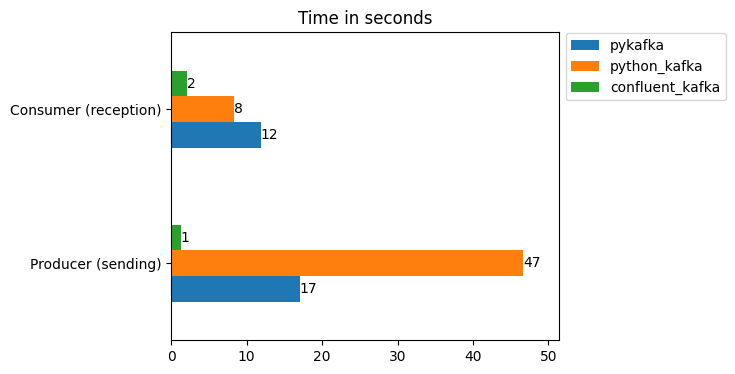

In [57]:
ax = pd.DataFrame(df_time)\
.plot(kind='barh', title='Time in seconds', figsize=(5, 4))
ax.set(xlabel='')

for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='edge')
    
ax.margins(x=0.1)

ax.legend(title='', bbox_to_anchor=(1, 1.02), loc='upper left')

# Understanding

Confluent Kafka is a Python wrapper around the librdkafka C library, so you have the guarantee it's going to be the most performant and compatible option.

 Kafka python is implemented fully in python. Slow speed performance.

Sources : https://towardsdatascience.com/3-libraries-you-should-know-to-master-apache-kafka-in-python-c95fdf8700f2  
https://stackoverflow.com/questions/73049329/python-kafka-consumer-library-that-supports-scalability-and-recoverability
http://activisiongamescience.github.io/2016/06/15/Kafka-Client-Benchmarking/